In [1]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copytree("drive/MyDrive/TEP","TEP")

Mounted at /content/drive


'TEP'

In [1]:
import pandas as pd

You will have to load the data in colab.

In [2]:
anom_train = pd.read_parquet("TEP/TEP_Faulty_Training.parquet")

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

Classification will only be done on the anomalous classes

In [4]:
# Preparing(batching) training set
simulation_length = 500
num_simulations = 10000
num_features = 52
batch_size = 64
num_classes = 20

y = anom_train['faultNumber'].values[::simulation_length]
X = anom_train.drop(["simulationRun","sample","faultNumber"],axis=1)
X = X.values.reshape((num_simulations, simulation_length, num_features))


In [6]:
print(np.unique(y))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [5]:
del anom_train #clearing colab space

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
del X, y

In [10]:
X_train.shape

(8000, 500, 52)

In [11]:
X_val.shape

(2000, 500, 52)

In [12]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [8]:
# Calculate means and standard deviations from the training set
train_means = X_train.mean(axis=(0, 1))
train_std = X_train.std(axis=(0, 1))

# Standardize the training set
X_train_scaled = (X_train - train_means) / (train_std)

# Standardize the validation set using the means and standard deviations from the training set
X_val_scaled = (X_val - train_means) / (train_std )


For simplicity, we will shift classes by 1, so the faultNumber=1 class will become faultNumber=0

In [9]:
# One-hot encode the target variables
num_classes = 20

# Subtract 1 from y_train and y_val to make them 0-indexed (0 to 19)
y_train_encoded = tf.keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val - 1, num_classes=num_classes)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled.astype(np.float32), y_train_encoded))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled.astype(np.float32), y_val_encoded))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
y_train_encoded[0].shape

(20,)

In [ ]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.])

In [10]:
del y_train_encoded, y_val_encoded, y_train,y_val,X_train,X_val

TCN implementation from scratch

In [3]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, SpatialDropout1D, Add, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from keras.regularizers import L2

In [4]:
def tcn_block(inputs, n_filters, kernel_size, dilations, dropout_rate,kernel_initializer="glorot_uniform"):

    conv_outputs = []
    x = inputs

    for d in dilations:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=d,
                   padding='causal', activation=None,kernel_initializer=kernel_initializer,kernel_regularizer=L2())(x)
        conv_outputs.append(x)

    x = Add()(conv_outputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    conv_outputs = []

    for d in dilations:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=d,
                   padding='causal', activation=None,kernel_initializer=kernel_initializer,kernel_regularizer=L2())(x)
        conv_outputs.append(x)

    x = Add()(conv_outputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Match dimensions for residual if necessary
    if inputs.shape[-1] != x.shape[-1]:
        residual = Conv1D(filters=x.shape[-1], kernel_size=1, padding='same')(inputs)
    else:
        residual = inputs

    return Add()([x, residual])


def build_tcn_model(num_features,
                    num_classes,
                    num_blocks=2,
                    n_filters=64,
                    kernel_size=3,
                    dilations=[1, 2, 4,8,16,32,64,128],
                    dropout_rate=0.1,
                    pooling=GlobalMaxPooling1D):
    inputs = Input(shape=(None,num_features)) #none seq length so as to take in any length(since test set is different)
    x = inputs
    for _ in range(num_blocks):
        x = tcn_block(x, n_filters=n_filters, kernel_size=kernel_size,
                      dilations=dilations, dropout_rate=dropout_rate)


    x = pooling()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [19]:
#scratch TCN
model = build_tcn_model(
    num_features=52,
    num_blocks=2,
    num_classes=20,
)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 52)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │     10,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 64)  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, None, 64)  │          0 │ re_lu[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_13[0][0] 

 Total params: 398,676 (1.52 MB)

 Trainable params: 398,164 (1.52 MB)

 Non-trainable params: 512 (2.00 KB)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])

In [9]:
from keras.callbacks import EarlyStopping

In [21]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=20,
                    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),EarlyStopping(patience=10)])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.5176 - loss: 12.7716 - val_accuracy: 0.8260 - val_loss: 0.8910 - learning_rate: 0.0100
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8400 - loss: 0.9156 - val_accuracy: 0.8430 - val_loss: 0.6667 - learning_rate: 0.0100
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8763 - loss: 0.5672 - val_accuracy: 0.8930 - val_loss: 0.4975 - learning_rate: 0.0100
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8932 - loss: 0.4480 - val_accuracy: 0.8995 - val_loss: 0.3685 - learning_rate: 0.0100
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8927 - loss: 0.4822 - val_accuracy: 0.8205 - val_loss: 1.9948 - learning_rate: 0.0100
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8998 - loss: 0.8804 - val_accuracy: 0.8985 - val_loss: 0.2951 - learning_rate: 0.0100
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.9007 -

In [22]:
model.save("tcn00.keras")

In [ ]:
# if not re-running training
#model = tf.keras.models.load_model("./models/tcn00.keras")

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 52)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, None, 64)  │     10,048 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_38[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None, 64)  │          0 │ conv1d_33[0][0],  │
│                     │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_36[0][0],  │
│                     │                   │            │ conv1d_37[0][0],  │
│                     │                   │            │ conv1d_38[0][0],  │
│                     │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ add_6[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_4 │ (None, None, 64)  │          0 │ re_lu_4[0][0]     │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_46[0][0] 

 Total params: 1,195,006 (4.56 MB)

 Trainable params: 398,164 (1.52 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 796,330 (3.04 MB)

In [24]:
import matplotlib.pyplot as plt

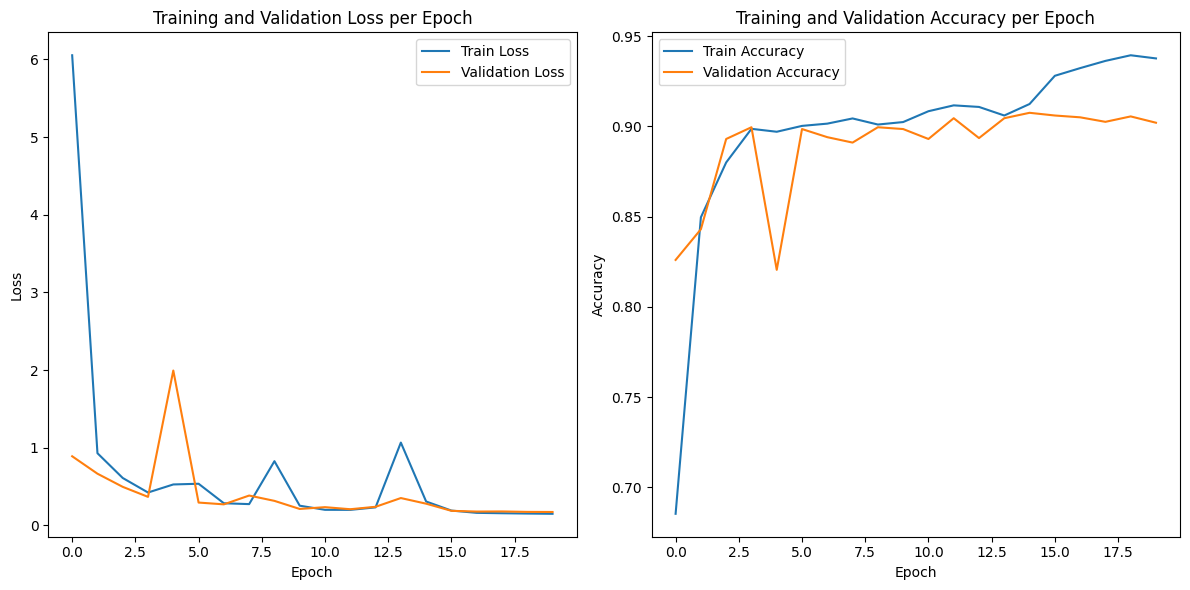

In [25]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Hints of overfitting after LR was reduced in last epochs, and very jumpy progression throughout due to high LR

With that said, we retrain the model on entire train dataset

In [26]:
del train_dataset

In [7]:
anom_train = pd.read_parquet("TEP/TEP_Faulty_Training.parquet")

X = anom_train.drop(["simulationRun","sample","faultNumber"],axis=1)
X = X.values.reshape((num_simulations, simulation_length, num_features))
y = anom_train['faultNumber'].values[::simulation_length]

del anom_train

train_mean = np.mean(X, axis=(0, 1))
train_std = np.std(X, axis=(0, 1))

X_scaled = (X - train_mean) / train_std
y_encoded = tf.keras.utils.to_categorical(y - 1, num_classes=num_classes)

del X

train_dataset = tf.data.Dataset.from_tensor_slices((X_scaled.astype(np.float32), y_encoded))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
model00 = build_tcn_model(num_blocks=2,
                    num_features=52,
                    num_classes=20)

In [10]:
model00.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])

In [12]:
history0 = model00.fit(train_dataset,epochs=20,
                    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3,monitor="loss"),EarlyStopping(patience=10,monitor="loss")])

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - accuracy: 0.5832 - loss: 11.2258 - learning_rate: 0.0100
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.8533 - loss: 0.6062 - learning_rate: 0.0100
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8824 - loss: 0.6679 - learning_rate: 0.0100
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8952 - loss: 0.5289 - learning_rate: 0.0100
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8983 - loss: 0.5284 - learning_rate: 0.0100
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9051 - loss: 0.3591 - learning_rate: 0.0100
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9063 - loss: 0.5365 - learning_rate: 0.0100
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9067 - loss: 0.3855 - learning_rate: 0.0100
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9075 - loss: 0.2453 - learning_rat

In [ ]:
model00.save("TCN0.keras")

In [ ]:
# if not re-running training
#model00 = tf.keras.models.load_model("./models/TCN0.keras")

In [14]:
model00.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 52)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │     10,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 64)  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, None, 64)  │          0 │ re_lu[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, None, 64)  │     12,352 │ conv1d_13[0][0] 

 Total params: 1,195,006 (4.56 MB)

 Trainable params: 398,164 (1.52 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 796,330 (3.04 MB)